## Where do embeddings come from?

The **vector embedding** captures the **meaning of the underlying data**. And we can think of vector embeddings as machine-understandable format of the data. 

**Vector databases** come from the ability to represent and embed data as **numbers** using neural networks. 

We'll start by building an autoencoder architecture to embed images into vectors. 

Then, we'll explore what it means for data objects to be similar or dissimilar and how to quantify this using their vector representations.

### Embedding MNIST images and NLP sentences into vectors.

An autoencoder works by **compressing** (by encoder) and **decompressing** (by decoder) data. 

For example, using the MNIST handwritten digits dataset, 
- a 28x28 pixel image (784 dimensions) is passed through an **encoder** to *compress* it into a smaller vector. 
- The **decoder** then reconstructs the image from this vector. 


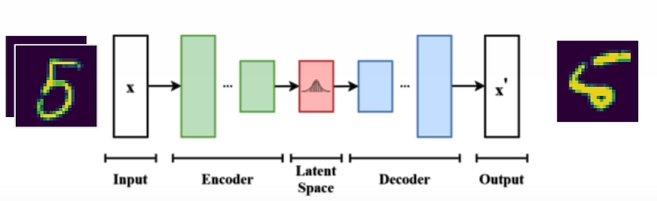

[Source](https://en.wikipedia.org/wiki/Variational_autoencoder)

Initially, the output may not match the input, but through **training**—adjusting the model's internal weights—the results improve until the reconstructed image closely resembles the original. 

The key insight is that the **middle vector**, called the **embedding**, captures the meaning of the image.

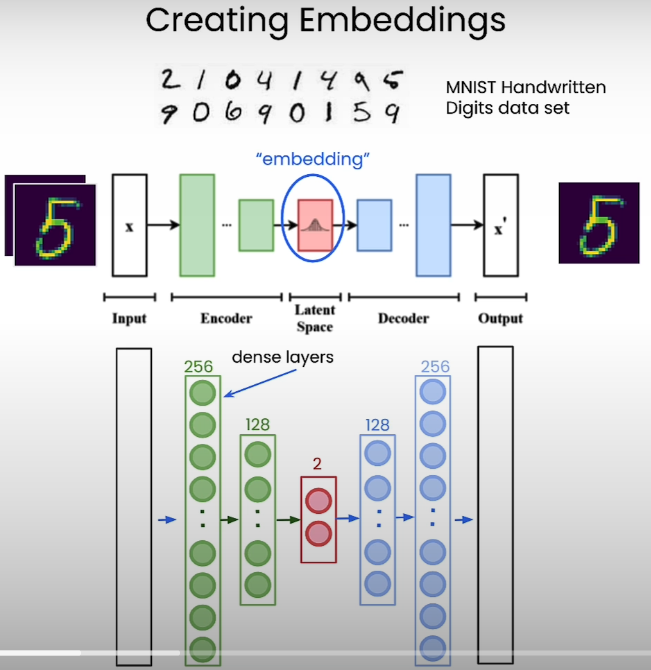

In this example, the embedding is intentionally set to two dimensions for visualization purposes, though real-world embeddings often have hundreds or thousands of dimensions. 

Autoencoders use **dense layers** to progressively reduce dimensions (e.g., 256 → 128 → 2) and then expand back to the original size. This process isn't limited to images—text, audio, and other data types can also be converted into machine-understandable vector embeddings that encapsulate their meaning.

In [180]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras import losses
from scipy.stats import norm

In [181]:
# Load data – training and test
(x_tr, y_tr), (x_te, y_te) = mnist.load_data()

We need to **normalize** this data which is basically taking this 28 by 28 image (784 dimensions) and then turning into a flattened structure (1 by 784). 

In [182]:
# Normalize and Reshape images (flatten)
x_tr, x_te = x_tr.astype('float32')/255., x_te.astype('float32')/255.
x_tr_flat, x_te_flat = x_tr.reshape(x_tr.shape[0], -1), x_te.reshape(x_te.shape[0], -1)

In [183]:
print(x_tr.shape, x_te.shape)
print(x_tr_flat.shape, x_te_flat.shape)

(60000, 28, 28) (10000, 28, 28)
(60000, 784) (10000, 784)


Let's look at an example of an input image and we can see that this one looks very much like a zero. 

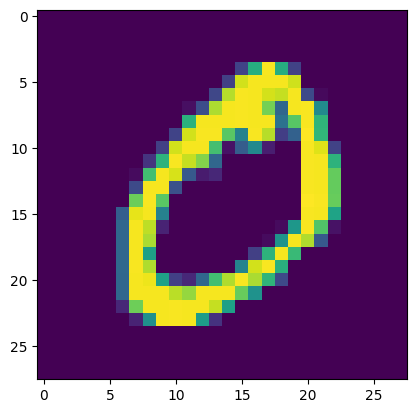

In [184]:
# Example of a training image
plt.imshow(x_tr[1]);

The batch size here is gonna be 100 objects, and it will run across 50 epochs. And then, we'll start with 256 dimensions for a hidden state and the objective is to generate vector embeddings of 2 dimensions.

In [185]:
# Neural Network Parameters
batch_size, n_epoch = 100, 50
n_hidden, z_dim = 256, 2

We need to construct a sampling function which will allow us to grab a number of images during the training phase. 

In [186]:
# Sampling function - Updated for new Keras API
def sampling(args):
    mu, log_var = args
    eps = K.random_normal(shape=(K.shape(mu)[0], z_dim), mean=0., stddev=1.0)
    return mu + K.exp(0.5 * log_var) * eps

We need to construct an encoder which will have two dense layers. The first one will have a dimension of 256. The next one will have dimensions of 128. Next, we need to normalize the data. 

In [187]:
# Encoder - from 784->256->128->2
inputs_flat = Input(shape=(x_tr_flat.shape[1:]))
x_flat = Dense(n_hidden, activation='relu')(inputs_flat) # first hidden layer
x_flat = Dense(n_hidden//2, activation='relu')(x_flat)  # second hidden layer

# hidden state, which we will pass into the Model to get the Encoder.
mu_flat = Dense(z_dim)(x_flat)
log_var_flat = Dense(z_dim)(x_flat)
z_flat = Lambda(sampling, output_shape=(z_dim,))([mu_flat, log_var_flat])

Let's build a matching decoder in a very similar way, this time starting from two dimensions, we'll be moving into 128 and 256 dimensions over here. 

In [188]:
#Decoder - from 2->128->256->784
latent_inputs = Input(shape=(z_dim,))

z_decoder1 = Dense(n_hidden//2, activation='relu')
z_decoder2 = Dense(n_hidden, activation='relu')
y_decoder = Dense(x_tr_flat.shape[1], activation='sigmoid')

z_decoded = z_decoder1(latent_inputs)
z_decoded = z_decoder2(z_decoded)
y_decoded = y_decoder(z_decoded)

decoder_flat = Model(latent_inputs, y_decoded, name="decoder_conv")

outputs_flat = decoder_flat(z_flat)

This is our loss function to train the autoencoder, which is also known as **variational autoencoder**. And basically, the idea here that is optimized to train too much so that the inputs match outputs in a really good fashion.

In [189]:
# Create a custom VAE model class
import tensorflow as tf
from tensorflow.keras.layers import Layer

class VAE(Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstruction = self.decoder(z)
        return reconstruction

    def test_step(self, data):
        z_mean, z_log_var, z = self.encoder(data)
        reconstruction = self.decoder(z)
        reconstruction_loss = tf.reduce_mean(
            tf.keras.losses.binary_crossentropy(data, reconstruction)
        ) * x_tr_flat.shape[1]
        kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
        total_loss = reconstruction_loss + kl_loss

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            # Fixed reconstruction loss calculation
            reconstruction_loss = tf.reduce_mean(
                tf.keras.losses.binary_crossentropy(data, reconstruction)
            ) * x_tr_flat.shape[1]
            # Fixed KL divergence loss calculation
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

# Create encoder model that returns mu, log_var, and z
encoder_inputs = Input(shape=(x_tr_flat.shape[1:]))
x = Dense(n_hidden, activation='relu')(encoder_inputs)
x = Dense(n_hidden//2, activation='relu')(x)
z_mean = Dense(z_dim)(x)
z_log_var = Dense(z_dim)(x)
z = Lambda(sampling, output_shape=(z_dim,))([z_mean, z_log_var])
encoder = Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

# Create VAE model
vae_flat = VAE(encoder, decoder_flat)
vae_flat.compile(optimizer='adam')

We have all the pieces, we can begin training that will run across 50 epochs and then each time training across 100 objects.

In [190]:
# train - Updated for custom VAE model
vae_flat.fit(
    x_tr_flat,
    shuffle=True,
    epochs=n_epoch,
    batch_size=batch_size,
    validation_data=(x_te_flat,),
    verbose=1
)

Epoch 1/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - kl_loss: 7.5832 - loss: 223.3703 - reconstruction_loss: 215.7870 - val_kl_loss: 4.6657 - val_loss: 168.4387 - val_reconstruction_loss: 163.7730
Epoch 2/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - kl_loss: 4.8205 - loss: 166.4223 - reconstruction_loss: 161.6017 - val_kl_loss: 4.8779 - val_loss: 162.3565 - val_reconstruction_loss: 157.4786
Epoch 3/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - kl_loss: 5.2262 - loss: 160.3800 - reconstruction_loss: 155.1537 - val_kl_loss: 5.5251 - val_loss: 157.3683 - val_reconstruction_loss: 151.8432
Epoch 4/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - kl_loss: 5.5625 - loss: 156.2352 - reconstruction_loss: 150.6727 - val_kl_loss: 5.5067 - val_loss: 154.5016 - val_reconstruction_loss: 148.9948
Epoch 5/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - kl_loss: 5.7231 - loss: 153.3870 - reconstruction_loss: 147.6639 - val_kl_loss: 5.7509 - val_loss: 153.0469 - val_reconstruction_loss: 147.2960
Epoch 6/50

### Visualize Embeddings

The training is done, so we can go and visualize our data. Let's start and build a flat encoder, and then we can add a piece of code to plot our vector embeddings onto a graph.

In [191]:
# Build encoder for inference - Updated for new structure
encoder_f = encoder  # Use the encoder we created above

And we can see in here that similar vectors are clustered together within the vector embedding space, and then just like we can see that zeros are close together here, nines are close together in here, and the whole space is actually demonstrated or displayed in a two-dimensional space. And those two dimensions are the two dimensions that we have inside the vector embedding.

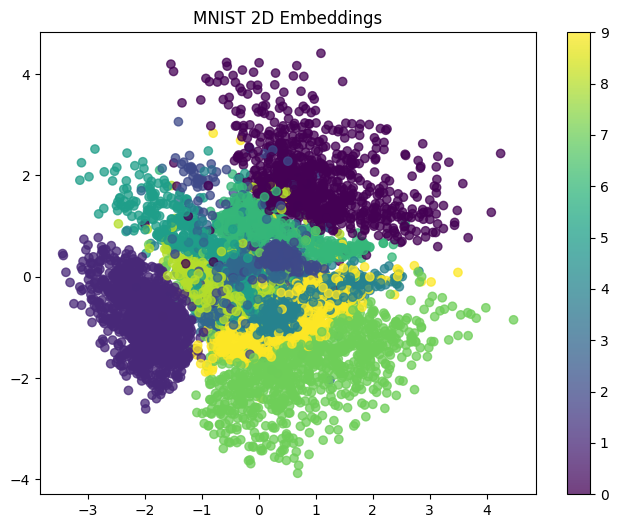

In [192]:
# Plot of the digit classes in the latent space
z_mean, z_log_var, z_sample = encoder_f.predict(x_te_flat, batch_size=batch_size, verbose=0)
plt.figure(figsize=(8, 6))
plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_te, alpha=0.75)
plt.title('MNIST 2D Embeddings')
plt.colorbar()
plt.show()

## Example: compare three embeddings

Now, we can get into a phase of comparing vector embeddings. Let's grab three different images. So, we'll grab one zero, and  another zero. and let's grab one image that represents digit number one.

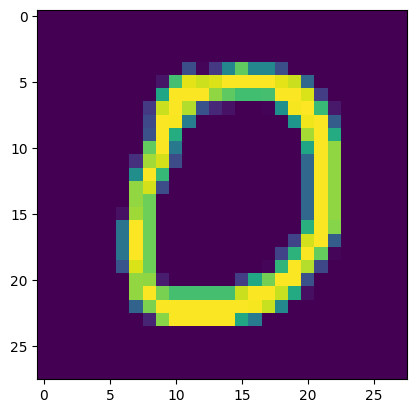

In [193]:
plt.imshow(x_te_flat[10].reshape(28,28));

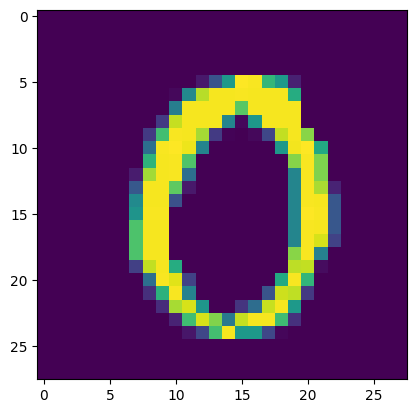

In [194]:
plt.imshow(x_te_flat[13].reshape(28,28));

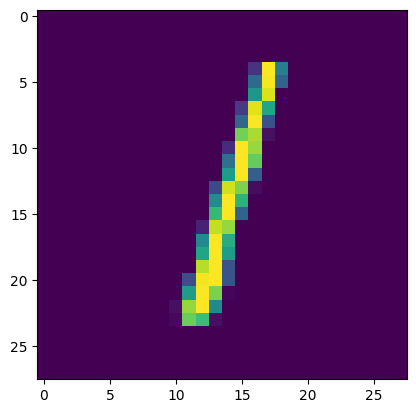

In [195]:
plt.imshow(x_te_flat[2].reshape(28,28));

If we grab these three objects and we can call our function to generate vector embeddings. So, `zero A`, `zero B`, and `one` will contain the vector embedding values that we need. And if we print them, we can see the vectors and we can already see that the two zeros are kind of similar to each other while the vector that represents digit one is actually quite different.

In [196]:
# calculate vectors for each digit
zero_A = z_mean[10]
zero_B = z_mean[13]
one = z_mean[2]

print(f"Embedding for the first ZERO is  {zero_A}")
print(f"Embedding for the second ZERO is {zero_B}")
print(f"Embedding for the ONE is         {one}")

Embedding for the first ZERO is  [1.1068685 1.6116291]
Embedding for the second ZERO is [0.7790256 1.4558909]
Embedding for the ONE is         [-2.6185617 -0.831637 ]


We can also do something very similar with text embeddings.

## Using more advanced models based on the Transformer architechture we can embed sentences aswell.

In [197]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

In [198]:
#Sentences we want to encode. Example:
sentence = ['The team enjoyed the hike through the meadow',
            'The national park had great views',
            'Olive oil drizzled over pizza tastes delicious']

If we grab a sentence transformer like this and then grab a few sentences like this, we can generate vector embeddings for each of those sentences over here, which will have values like this.

In [199]:
#Sentences are encoded by calling model.encode()
embedding = model.encode(sentence)

#Preview the embeddings
print(embedding)

[[ 0.37061968  0.26414266  0.21265665 ...  0.14994559 -0.2579493
  -0.23970751]
 [ 0.6693332   0.40094957 -0.48208398 ...  0.10645877 -1.506716
  -0.01547347]
 [-0.2655591   0.11172403 -0.14733021 ...  0.4219747   0.8839462
   0.10763929]]


In [200]:
embedding.shape

(3, 384)

And to illustrate the shapes of each of those vectors, let's just run quickly embedding shape. And we can see that in here we have three vectors of 384 dimensions. So, let's try to represent those vectors in a visual way. So, we are going to plot each of those vectors as a very nice barcode, or a series of barcodes. And we can already see that the first two vectors are kind of similar-ish to each other, while the third vector is quite different.

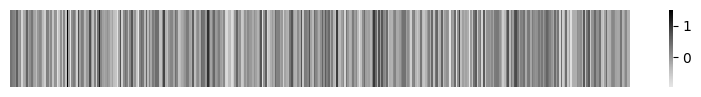

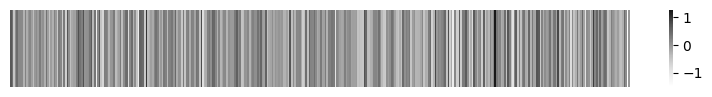

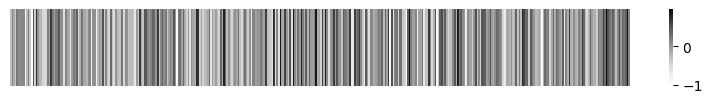

In [201]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(embedding[0].reshape(-1,384),cmap="Greys",center=0,square=False)
plt.gcf().set_size_inches(10,1)
plt.axis('off')
plt.show()

sns.heatmap(embedding[1].reshape(-1,384),cmap="Greys",center=0,square=False)
plt.gcf().set_size_inches(10,1)
plt.axis('off')
plt.show()

sns.heatmap(embedding[2].reshape(-1,384),cmap="Greys",center=0,square=False)
plt.gcf().set_size_inches(10,1)
plt.axis('off')
plt.show()

## How can we measure the distance between these Image and Sentence Embeddings?

To quantify **similarity**, we use distance metrics. There are many ways to calculate the distances between two vectors.

Here we will cover 4 distance metrics that are being used in the context of vector databases:
- **Euclidean Distance(L2)**: Measures the straight-line distance between points. Smaller values indicate greater similarity.
- **Manhattan Distance(L1)**: Sums absolute differences along axes, useful for grid-like paths.
- **Dot Product**: Projects one vector onto another. Higher values suggest similarity, while negative values imply dissimilarity.
- **Cosine Distance**: Measures the angle between vectors. Near-zero values indicate alignment (similarity), while larger angles imply divergence.

For natural language processing, **dot product** and **cosine distance** are most common. For example, comparing sentence embeddings with these metrics reveals how closely their meanings align.

### Euclidean Distance(L2)
The length of the shortest path between two points or vectors.

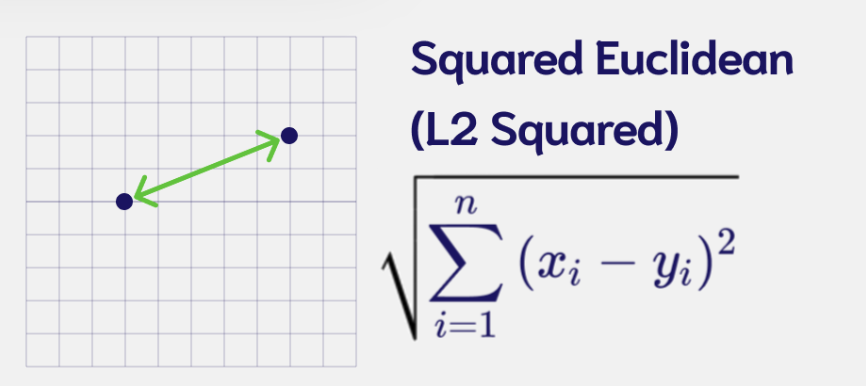

In [202]:
# Euclidean Distance
L2 = [(zero_A[i] - zero_B[i])**2 for i in range(len(zero_A))]
L2 = np.sqrt(np.array(L2).sum())
print(L2)

0.36295366


In [203]:
#An alternative way of doing this
np.linalg.norm((zero_A - zero_B), ord=2)

np.float32(0.36295366)

In [204]:
#Calculate L2 distances
print("Distance zeroA-zeroB:", np.linalg.norm((zero_A - zero_B), ord=2))
print("Distance zeroA-one:  ", np.linalg.norm((zero_A - one), ord=2))
print("Distance zeroB-one:  ", np.linalg.norm((zero_B - one), ord=2))

Distance zeroA-zeroB: 0.36295366
Distance zeroA-one:   4.455152
Distance zeroB-one:   4.0958986


### Manhattan Distance(L1)
Distance between two points if one was constrained to move only along one axis at a time.

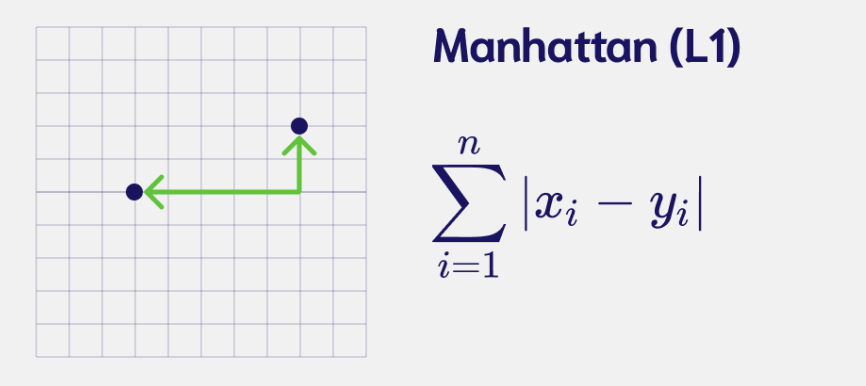

In [205]:
# Manhattan Distance
L1 = [zero_A[i] - zero_B[i] for i in range(len(zero_A))]
L1 = np.abs(L1).sum()

print(L1)

0.48358113


In [206]:
#an alternative way of doing this is
np.linalg.norm((zero_A - zero_B), ord=1)

np.float32(0.48358113)

In [207]:
#Calculate L1 distances
print("Distance zeroA-zeroB:", np.linalg.norm((zero_A - zero_B), ord=1))
print("Distance zeroA-one:  ", np.linalg.norm((zero_A - one), ord=1))
print("Distance zeroB-one:  ", np.linalg.norm((zero_B - one), ord=1))

Distance zeroA-zeroB: 0.48358113
Distance zeroA-one:   6.1686964
Distance zeroB-one:   5.6851153


### Dot Product
Measures the magnitude of the projection of one vector onto the other.

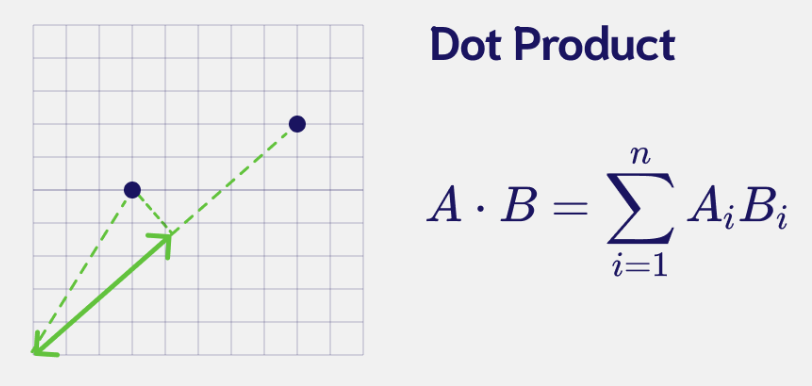

In [208]:
# Dot Product
np.dot(zero_A,zero_B)

np.float32(3.208635)

In [209]:
# Calculate Dot products
print("Distance zeroA-zeroB:", np.dot(zero_A, zero_B))
print("Distance zeroA-one:  ", np.dot(zero_A, one))
print("Distance zeroB-one:  ", np.dot(zero_B, one))

Distance zeroA-zeroB: 3.208635
Distance zeroA-one:   -4.2386937
Distance zeroB-one:   -3.2506995


### Cosine Distance
Measure the difference in directionality between vectors.

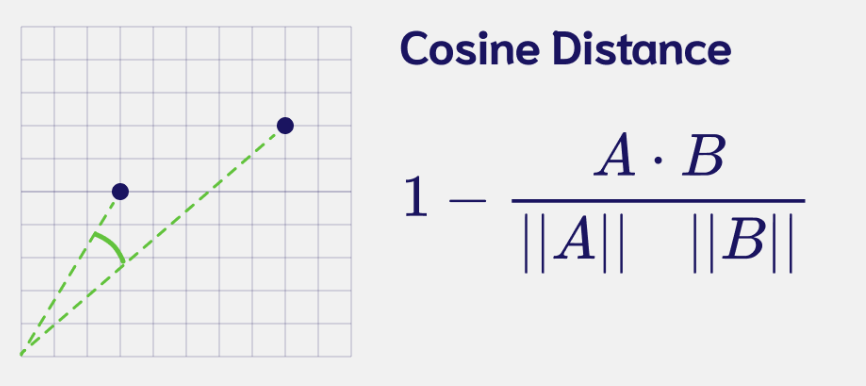

In [210]:
# Cosine Distance
cosine = 1 - np.dot(zero_A,zero_B)/(np.linalg.norm(zero_A)*np.linalg.norm(zero_B))
print(f"{cosine:.6f}")

0.006098


In [211]:
zero_A/zero_B

array([1.4208372, 1.1069711], dtype=float32)

In [212]:
# Cosine Distance function
def cosine_distance(vec1,vec2):
  cosine = 1 - (np.dot(vec1, vec2)/(np.linalg.norm(vec1)*np.linalg.norm(vec2)))
  return cosine

In [213]:
#Cosine Distance
print(f"Distance zeroA-zeroB: {cosine_distance(zero_A, zero_B): .6f}")
print(f"Distance zeroA-one:   {cosine_distance(zero_A, one): .6f}")
print(f"Distance zeroB-one:   {cosine_distance(zero_B, one): .6f}")

Distance zeroA-zeroB:  0.006098
Distance zeroA-one:    1.789093
Distance zeroB-one:    1.716546


## Now with the sentence embeddings!

**Dot Product** and **Cosine Distance** are commonly used in the field of **NLP**, to evaluate how similar two sentence embeddings are.
So here we will only use those two.

- embedding0 - 'The team enjoyed the hike through the meadow'

- embedding1 - The national park had great views'

- embedding2 - 'Olive oil drizzled over pizza tastes delicious'

In [214]:
# Dot Product
print("Distance 0-1:", np.dot(embedding[0], embedding[1]))
print("Distance 0-2:", np.dot(embedding[0], embedding[2]))
print("Distance 1-2:", np.dot(embedding[1], embedding[2]))

Distance 0-1: 26.497887
Distance 0-2: 2.0785775
Distance 1-2: 4.019213


In [215]:
# Cosine Distance
print("Distance 0-1: ", cosine_distance(embedding[0], embedding[1]))
print("Distance 0-2: ", cosine_distance(embedding[0], embedding[2]))
print("Distance 1-2: ", cosine_distance(embedding[1], embedding[2]))

Distance 0-1:  0.5350336
Distance 0-2:  0.9639393
Distance 1-2:  0.9288791


### Utility Methods

In [216]:
# Import utility functions for base64 image conversion
import sys
import os
sys.path.append('..')  # Add parent directory to path
from utils import figure_to_base64, image_file_to_base64, display_base64_image


Copy this HTML to your markdown cell:


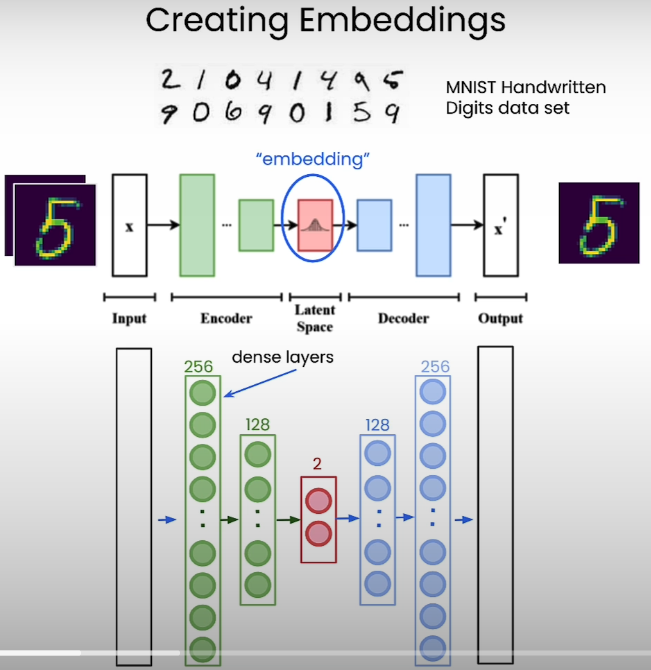

In [217]:
import sys

# Add parent directory to path
sys.path.append('..')

# Import utility functions for base64 image conversion
from utils import create_markdown_image, image_file_to_base64

# Convert image to base64
base64_str = image_file_to_base64("../images/embedding_generation.png")

# Create markdown HTML
markdown_html = create_markdown_image(base64_str, "Embedding Generation Process", width=600)
print("Copy this HTML to your markdown cell:")
print(markdown_html)